# Step 1: Install Dependencies

In [1]:
pip install tensorflow scikit-learn pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


# Step 2: Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 3: Load the Dataset

<ipython-input-3-80ef270fbc3a>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Time'] = pd.date_range('2021-01-01', periods=len(df), freq='H')


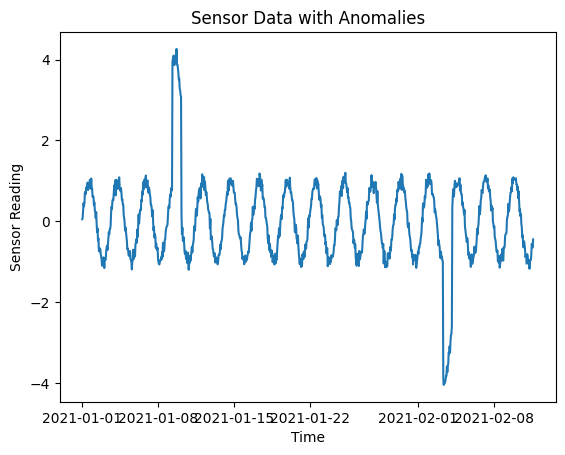

In [3]:
# Generating synthetic sensor data for the example
np.random.seed(42)

# Create synthetic data (time-series for a sensor reading like temperature)
time_steps = 1000
normal_data = np.sin(np.linspace(0, 100, time_steps)) + np.random.normal(0, 0.1, time_steps)

# Adding anomalies (for example, sudden spikes or dips in the data)
anomaly_data = normal_data.copy()
anomaly_data[200:220] = anomaly_data[200:220] + 3  # Artificial anomaly
anomaly_data[800:820] = anomaly_data[800:820] - 3  # Another anomaly

# Create a dataframe for visualization
df = pd.DataFrame(anomaly_data, columns=['Sensor Reading'])
df['Time'] = pd.date_range('2021-01-01', periods=len(df), freq='H')

# Visualizing the data
plt.plot(df['Time'], df['Sensor Reading'])
plt.title('Sensor Data with Anomalies')
plt.xlabel('Time')
plt.ylabel('Sensor Reading')
plt.show()


# Step 4: Preprocess the Data

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Sensor Reading']])

# Create sequences (X) and labels (y)
sequence_length = 60  # Using the past 60 time steps to predict the next time step
X = []
y = []

# Mark anomalies as 1, normal data as 0
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])  # Past 60 time steps data
    if i > 200 and i < 220:  # Artificial anomaly in this range
        y.append(1)
    elif i > 800 and i < 820:  # Another artificial anomaly
        y.append(1)
    else:
        y.append(0)

X, y = np.array(X), np.array(y)

# Reshape X to be compatible with LSTM input (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shape of the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (752, 60, 1)
X_test shape: (188, 60, 1)


# Step 5: Build the Anomaly Detection Model (LSTM)

In [5]:
# Build the LSTM Model for anomaly detection
model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer (sigmoid for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# Step 6: Train the Model

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8428 - loss: 0.5292 - val_accuracy: 0.9574 - val_loss: 0.1825
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9681 - loss: 0.1472 - val_accuracy: 0.9574 - val_loss: 0.1750
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9532 - loss: 0.1940 - val_accuracy: 0.9574 - val_loss: 0.1756
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9727 - loss: 0.1266 - val_accuracy: 0.9574 - val_loss: 0.1760
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9595 - loss: 0.1687 - val_accuracy: 0.9574 - val_loss: 0.1756
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9632 - loss: 0.1620 - val_accuracy: 0.9574 - val_loss: 0.1757
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9551 - loss: 0.1809 - val_accuracy: 0.9574 - val_loss: 0.1760
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9605 - loss: 0.1704 - val_accuracy: 0.9574 - v

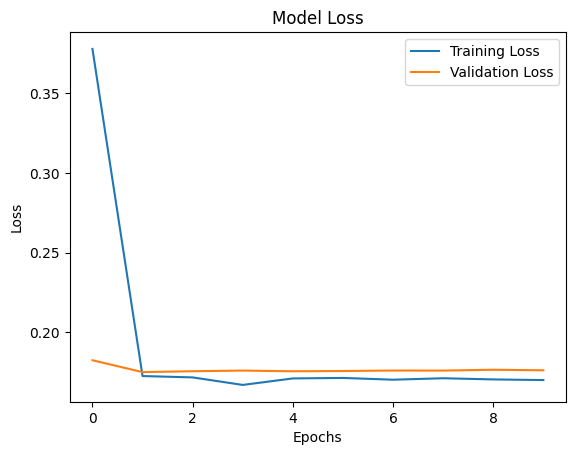

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()